## This notebook will construct the nodes and edges that we will build our graph with

In this notebook we use peaks that have been extracted from the spectra to construct a graph. Each node in the graph will be a peak, with attributes such as width of that peak, its Status, etc. . Edges between two peaks will exist based on two conditions. The first condition is that every peak, within a sample, will be connected to each other. The second condition is based on matching grid-slots. This means we will parse our spectra into grid squares and if two peaks are present in the same grid square, a relationjship will exist between them.

These relationships will be weighted by distance. That means we treat each peak as a point in a co-ordinate plane and calculate the euclidean distance between them. As the peaks in the same grid-slots will inherently be closer to each other than the peaks in the same sample, we will separately minmax scale these distances, so as not to give prefernece to one type of relationship. As well as this, in a graph, a larger weight is meant to represent a stronger connection between nodes. In order to account for this, we will get the inverse of our scaled distance to used as the relationship weight as we want peaks that are closer together to have a stronger connection.

This is similar to a previous graph we made(graph 1.4) except this time we are using Baseline corrected and scaled versions of the spectra.

Import relevant libraries and import raw data

In [1]:
import seaborn as sns
import pandas as pd
from scipy.signal import find_peaks
import numpy as np
import matplotlib.pyplot as plt

In [2]:
neo4j_path = 'C:/Users/stang/.Neo4jDesktop/relate-data/dbmss'
neo4j_dbms = 'dbms-d0a05d27-d2ec-404f-a7c3-e7f4b6a97351'

In [3]:
df = pd.read_csv("../../data/current_clean_spectrum.csv")

Here we use scipy's function "find_peaks" to find all peaks in each individual spectra sample as well as pulling featurse such as prominence and width of peaks

In [4]:
peaks = []
widths = []
prom = []

for _, group in df.groupby('SpecID'):
    peak_index, weights = find_peaks(x=group['Absorbance'], prominence=42, width=6)
    peaks += list(group.iloc[peak_index].index.values)
    widths += list(weights['widths'])
    prom += list(weights['prominences'])

In [5]:
print(len(peaks))

36947


Below shows a scatterplot of the coordinates of all the peaks we have found

<Axes: xlabel='WaveNumber', ylabel='Absorbance'>

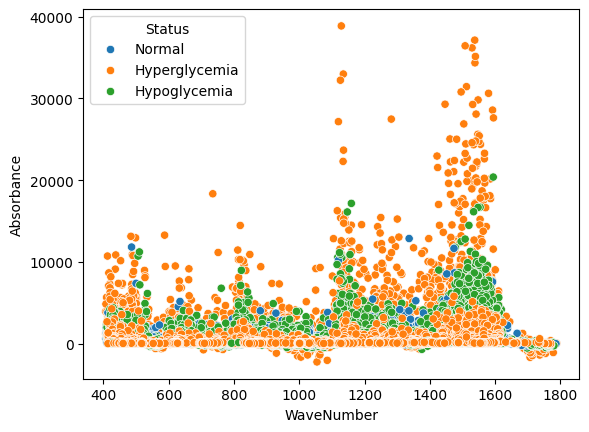

In [6]:
sns.scatterplot(data=df.iloc[peaks].reset_index(), x="WaveNumber", y="Absorbance", hue="Status")

We then add the peak information to our main dataframe

In [7]:
peak_df = df.iloc[peaks]
peak_df['Widths'] = widths
peak_df['Prominences'] = prom

C:\Users\stang\AppData\Local\Temp\ipykernel_22116\2901317241.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peak_df['Widths'] = widths
C:\Users\stang\AppData\Local\Temp\ipykernel_22116\2901317241.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peak_df['Prominences'] = prom


In [8]:
peak_df

,SpecID,Seq,WaveNumber,SurID,Status,Absorbance,Widths,Prominences
316,201210-1-00,609,616.17310,201210-1,Normal,130.703736,54.553283,129.426483
430,201210-1-00,723,694.07745,201210-1,Normal,158.758043,45.945437,168.337399
731,201210-1-00,1024,899.77222,201210-1,Normal,98.215234,118.958656,117.622201
884,201210-1-00,1177,1004.32800,201210-1,Normal,94.027784,83.780231,87.483789
1525,201210-1-00,1818,1442.36900,201210-1,Normal,83.545411,59.833060,68.228453
...,...,...,...,...,...,...,...,...
6226999,210526-3-49,381,460.36447,210526-3,Hyperglycemia,42.299576,75.414495,51.427760
6227364,210526-3-49,746,709.79498,210526-3,Hyperglycemia,60.140828,109.016791,66.042602
6227565,210526-3-49,947,847.15265,210526-3,Hyperglycemia,44.883433,103.988687,47.565390
6227790,210526-3-49,1172,1000.91110,210526-3,Hyperglycemia,58.863972,40.827018,61.091590


We then use the function to assign each peak we have found to a grid slot. We have speicified the slot sizes as they give a meaningful overlap to build our graph

In [9]:
def assign_to_grid(x, y, x_slot_size, y_slot_size):

    x_index = int(x / x_slot_size)
    y_index = int(y / y_slot_size)

    return x_index, y_index

In [10]:
# Set the size of the grid slots
WaveNumber_slot_size = 200
Absorbance_slot_size = 50

peak_df['GridSlot'] = peak_df.apply(lambda row: assign_to_grid(row['WaveNumber'], row['Absorbance'], WaveNumber_slot_size, Absorbance_slot_size), axis=1)

C:\Users\stang\AppData\Local\Temp\ipykernel_22116\916937857.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peak_df['GridSlot'] = peak_df.apply(lambda row: assign_to_grid(row['WaveNumber'], row['Absorbance'], WaveNumber_slot_size, Absorbance_slot_size), axis=1)


In [11]:
peak_df['GridSlot'].nunique()

1183

In [12]:
peak_df.head()

,SpecID,Seq,WaveNumber,SurID,Status,Absorbance,Widths,Prominences,GridSlot
316,201210-1-00,609,616.17310,201210-1,Normal,130.703736,54.553283,129.426483,"(3, 2)"
430,201210-1-00,723,694.07745,201210-1,Normal,158.758043,45.945437,168.337399,"(3, 3)"
731,201210-1-00,1024,899.77222,201210-1,Normal,98.215234,118.958656,117.622201,"(4, 1)"
884,201210-1-00,1177,1004.32800,201210-1,Normal,94.027784,83.780231,87.483789,"(5, 1)"
1525,201210-1-00,1818,1442.36900,201210-1,Normal,83.545411,59.833060,68.228453,"(7, 1)"


We will use "Node_ID" to find distances between peaks later on for our edge construction

In [13]:
peak_df['Node_ID'] = peak_df.index

C:\Users\stang\AppData\Local\Temp\ipykernel_22116\412265839.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peak_df['Node_ID'] = peak_df.index


In [14]:
peak_df = peak_df.drop(columns=['Seq', 'SurID'])

Here we join the peak dataframe with itself in order to match peaks within the same Spectra Sample

In [15]:
same_sample = pd.merge(peak_df, peak_df[['SpecID', 'Node_ID']], on='SpecID', how='outer', suffixes=('_src', '_dst'))
same_sample['LINK:TYPE'] = 'SAMPLE'

In [16]:
same_sample.head()

,SpecID,WaveNumber,Status,Absorbance,Widths,Prominences,GridSlot,Node_ID_src,Node_ID_dst,LINK:TYPE
0,201210-1-00,616.1731,Normal,130.703736,54.553283,129.426483,"(3, 2)",316,316,SAMPLE
1,201210-1-00,616.1731,Normal,130.703736,54.553283,129.426483,"(3, 2)",316,430,SAMPLE
2,201210-1-00,616.1731,Normal,130.703736,54.553283,129.426483,"(3, 2)",316,731,SAMPLE
3,201210-1-00,616.1731,Normal,130.703736,54.553283,129.426483,"(3, 2)",316,884,SAMPLE
4,201210-1-00,616.1731,Normal,130.703736,54.553283,129.426483,"(3, 2)",316,1525,SAMPLE


We then join the dataframe with itself again, this time to match peaks in the same grid slot

In [17]:
same_grid_slot = pd.merge(peak_df, peak_df[['GridSlot', 'Node_ID']], on='GridSlot', how='outer', suffixes=('_src', '_dst'))
same_grid_slot['LINK:TYPE'] = 'GRID'

In [18]:
same_grid_slot.head()

,SpecID,WaveNumber,Status,Absorbance,Widths,Prominences,GridSlot,Node_ID_src,Node_ID_dst,LINK:TYPE
0,201210-1-00,616.1731,Normal,130.703736,54.553283,129.426483,"(3, 2)",316,316,GRID
1,201210-1-00,616.1731,Normal,130.703736,54.553283,129.426483,"(3, 2)",316,2373,GRID
2,201210-1-00,616.1731,Normal,130.703736,54.553283,129.426483,"(3, 2)",316,4530,GRID
3,201210-1-00,616.1731,Normal,130.703736,54.553283,129.426483,"(3, 2)",316,8628,GRID
4,201210-1-00,616.1731,Normal,130.703736,54.553283,129.426483,"(3, 2)",316,10566,GRID


We the combine these new dataframes together to form our relationship dataframe and we perform some clean to get rid of columns we don't need and renaming columns to get them ready for neo4j

In [19]:
graph_df = pd.concat([same_sample, same_grid_slot], ignore_index=True)

In [20]:
del same_sample
del same_grid_slot

In [21]:
graph_df = graph_df.drop(columns=['SpecID', 'GridSlot', 'WaveNumber', 'Absorbance', 'Status', 'Widths', 'Prominences'])

In [22]:
graph_df = graph_df.rename(columns={'Node_ID_src':':START_ID', 'Node_ID_dst':':END_ID'})

In [23]:
graph_df.head()

,:START_ID,:END_ID,LINK:TYPE
0,316,316,SAMPLE
1,316,430,SAMPLE
2,316,731,SAMPLE
3,316,884,SAMPLE
4,316,1525,SAMPLE


This gets rid of relationships that match nodes to themselves

In [24]:
graph_df = graph_df[graph_df[':START_ID'] != graph_df[':END_ID']]

We make use of built in numpy functions to efficiently calculate distances between all of our relationships

In [25]:
wave = peak_df['WaveNumber']
absorb = peak_df['Absorbance']

src_indices = graph_df[':START_ID'].values
dst_indices = graph_df[':END_ID'].values

src_coords = np.column_stack((wave[src_indices], absorb[src_indices]))
dst_coords = np.column_stack((wave[dst_indices], absorb[dst_indices]))

distances = np.linalg.norm(src_coords - dst_coords, axis=1)

dist = distances.tolist()

In [26]:
graph_df['DIST'] = dist

In [27]:
graph_df.head()

,:START_ID,:END_ID,LINK:TYPE,DIST
1,316,430,SAMPLE,82.801763
2,316,731,SAMPLE,285.453961
3,316,884,SAMPLE,389.883767
4,316,1525,SAMPLE,827.540677
5,316,1782,SAMPLE,1002.375922


In [28]:
from sklearn.preprocessing import MinMaxScaler

sample_data = graph_df[graph_df['LINK:TYPE'] == 'SAMPLE']
grid_data = graph_df[graph_df['LINK:TYPE'] == 'GRID']
scaler = MinMaxScaler()

sample_data['DIST'] = 1 - scaler.fit_transform(sample_data[['DIST']])
grid_data['DIST'] = 1 -scaler.fit_transform(grid_data[['DIST']])

scaled_df = pd.concat([sample_data, grid_data])

C:\Users\stang\AppData\Local\Temp\ipykernel_22116\3287303899.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_data['DIST'] = 1 - scaler.fit_transform(sample_data[['DIST']])
C:\Users\stang\AppData\Local\Temp\ipykernel_22116\3287303899.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grid_data['DIST'] = 1 -scaler.fit_transform(grid_data[['DIST']])


In [29]:
scaled_df.rename(columns={'DIST':'DIST:float'}, inplace=True)

In [30]:
scaled_df

,:START_ID,:END_ID,LINK:TYPE,DIST:float
1,316,430,SAMPLE,0.998276
2,316,731,SAMPLE,0.993127
3,316,884,SAMPLE,0.990473
4,316,1525,SAMPLE,0.979352
5,316,1782,SAMPLE,0.974910
...,...,...,...,...
15967336,5180919,4064270,GRID,0.821456
15967363,5191824,5195802,GRID,0.613859
15967364,5195802,5191824,GRID,0.613859
15967374,5363997,5503332,GRID,0.974429


In [31]:
scaled_df.to_csv(f"{neo4j_path}/{neo4j_dbms}/import/relationships.csv", index=False)

Finally, we clean and rename columsn in our main node dataframe to get it ready for neo4j

In [32]:
peak_df

,SpecID,WaveNumber,Status,Absorbance,Widths,Prominences,GridSlot,Node_ID
316,201210-1-00,616.17310,Normal,130.703736,54.553283,129.426483,"(3, 2)",316
430,201210-1-00,694.07745,Normal,158.758043,45.945437,168.337399,"(3, 3)",430
731,201210-1-00,899.77222,Normal,98.215234,118.958656,117.622201,"(4, 1)",731
884,201210-1-00,1004.32800,Normal,94.027784,83.780231,87.483789,"(5, 1)",884
1525,201210-1-00,1442.36900,Normal,83.545411,59.833060,68.228453,"(7, 1)",1525
...,...,...,...,...,...,...,...,...
6226999,210526-3-49,460.36447,Hyperglycemia,42.299576,75.414495,51.427760,"(2, 0)",6226999
6227364,210526-3-49,709.79498,Hyperglycemia,60.140828,109.016791,66.042602,"(3, 1)",6227364
6227565,210526-3-49,847.15265,Hyperglycemia,44.883433,103.988687,47.565390,"(4, 0)",6227565
6227790,210526-3-49,1000.91110,Hyperglycemia,58.863972,40.827018,61.091590,"(5, 1)",6227790


In [33]:
peak_df.rename(columns={"Status":"Status:LABEL"}, inplace=True)

In [34]:
peak_df.rename(columns={'WaveNumber':'WaveNumber:float', 'Absorbance':'Absorbance:float', 'Widths':'Widths:float', 'Prominences':'Prominences:float', 'Node_ID':'Node_ID:ID'}, inplace=True)

In [35]:
peak_df.to_csv(f"{neo4j_path}/{neo4j_dbms}/import/nodes.csv", index=False)

In [36]:
from neo4j import GraphDatabase
import os
import pandas as pd
import shutil
import subprocess

This moves the nodes and relationships files from data/current_working_graph into the DBMS import folder.

At the moment this uses local paths, but the rest should be automated.

Then run the admin import command.

In [37]:
os_name = os.name

if os_name == 'nt':
    working_dir = f'{neo4j_path}/{neo4j_dbms}/bin'
    command = 'neo4j-admin database import full --nodes=import/nodes.csv --relationships=import/relationships.csv --overwrite-destination neo4j'
    result = subprocess.run(command, shell=True, cwd=working_dir, capture_output=True, text=True)
else:
    working_dir = f'{neo4j_path}/{neo4j_dbms}'
    command = [
    './bin/neo4j-admin', 'database', 'import', 'full',
    '--nodes=import/nodes.csv',
    '--relationships=import/relationships.csv',
    '--overwrite-destination',  'neo4j'
    ]
    result = subprocess.run(command, cwd=working_dir, stdout=subprocess.PIPE, stderr=subprocess.PIPE)


# Check if the command was successful
if result.returncode == 0:
    print("Import successful")
    print(result.stdout)
else:
    print("Error during import:")
    print(result.stderr)

Import successful
Neo4j version: 5.12.0
Importing the contents of these files into C:\Users\stang\.Neo4jDesktop\relate-data\dbmss\dbms-d0a05d27-d2ec-404f-a7c3-e7f4b6a97351\data\databases\neo4j:
Nodes:
  C:\Users\stang\.Neo4jDesktop\relate-data\dbmss\dbms-d0a05d27-d2ec-404f-a7c3-e7f4b6a97351\import\nodes.csv

Relationships:
  C:\Users\stang\.Neo4jDesktop\relate-data\dbmss\dbms-d0a05d27-d2ec-404f-a7c3-e7f4b6a97351\import\relationships.csv


Available resources:
  Total machine memory: 31.86GiB
  Free machine memory: 9.922GiB
  Max heap memory : 910.5MiB
  Max worker threads: 8
  Configured max memory: 8.189GiB
  High parallel IO: true

Cypher type normalization is enabled (disable with --normalize-types=false):
  Property type of 'WaveNumber' normalized from 'float' --> 'double' in C:\Users\stang\.Neo4jDesktop\relate-data\dbmss\dbms-d0a05d27-d2ec-404f-a7c3-e7f4b6a97351\import\nodes.csv
  Property type of 'Absorbance' normalized from 'float' --> 'double' in C:\Users\stang\.Neo4jDesktop\re

Run and connect to the Neo4j Database

In [38]:
from neo4j import GraphDatabase

uri = "neo4j://localhost:7687"
username = "neo4j"              # Neo4J username
#password = os.environ['NEO4J_Password']           # Neo4J password
password = '26622002'

# Create a driver instance
driver = GraphDatabase.driver(uri, auth=(username, password))

# Ensure you close the driver connection when your program ends
def close_driver():
    driver.close()

**First create the gds Graph Projection**

In [39]:
def project_graph(tx):
    query = """
    CALL gds.graph.project(
      'myGraph', 
      ['Normal', 'Hyperglycemia', 'Hypoglycemia'],
      {
        SAMPLE: {
          orientation: 'UNDIRECTED',
          properties: 'DIST'
        },
        GRID: {
          orientation: 'UNDIRECTED',
          properties: 'DIST'
        }
      }
    )
    """
    tx.run(query)

# Use a session to execute the graph projection
with driver.session() as session:
    session.execute_write(project_graph)

Define the graph algorithms.

In [40]:
def run_pagerank_centrality(tx):
    query = """
    CALL gds.pageRank.stream('myGraph', {
        relationshipWeightProperty: 'DIST'
    })
    YIELD nodeId, score
    RETURN gds.util.asNode(nodeId).SpecID AS name, gds.util.asNode(nodeId).Node_ID AS id, score
    ORDER BY score DESC, name ASC
    """
    results = tx.run(query)
    return [(record["name"], record["id"], record["score"]) for record in results]

In [41]:
def run_degree_centrality(tx):
    query = """
    CALL gds.degree.stream('myGraph', {
        relationshipWeightProperty: 'DIST'
    })
    YIELD nodeId, score
    RETURN gds.util.asNode(nodeId).SpecID AS name, gds.util.asNode(nodeId).Node_ID AS id, score
    ORDER BY score DESC, name ASC
    """
    results = tx.run(query)
    return [(record["name"], record["id"], record["score"]) for record in results]

In [42]:
def run_eigenvector_centrality(tx):
    query = """
    CALL gds.eigenvector.stream('myGraph', {
        relationshipWeightProperty: 'DIST'
    })
    YIELD nodeId, score
    RETURN gds.util.asNode(nodeId).SpecID AS name, gds.util.asNode(nodeId).Node_ID AS id, score
    ORDER BY score DESC, name ASC
    """
    results = tx.run(query)
    return [(record["name"], record["id"], record["score"]) for record in results]

In [43]:
def run_articlerank_centrality(tx):
    query = """
    CALL gds.articleRank.stream('myGraph', {
        relationshipWeightProperty: 'DIST'
    })
    YIELD nodeId, score
    RETURN gds.util.asNode(nodeId).SpecID AS name, gds.util.asNode(nodeId).Node_ID AS id, score
    ORDER BY score DESC, name ASC
    """
    results = tx.run(query)
    return [(record["name"], record["id"], record["score"]) for record in results]

In [44]:
def run_label_propagation_algorithm(tx):
    query = """
    CALL gds.labelPropagation.stream('myGraph', { relationshipWeightProperty: 'DIST' })
    YIELD nodeId, communityId AS Community
    RETURN gds.util.asNode(nodeId).SpecID AS name, gds.util.asNode(nodeId).Node_ID AS id, Community
    ORDER BY Community, name
    """
    results = tx.run(query)
    return [(record["name"], record["id"], record["Community"]) for record in results]

In [45]:
def run_leiden_algorithm(tx):
    query = """
    CALL gds.leiden.stream('myGraph', { relationshipWeightProperty: 'DIST' })
    YIELD nodeId, communityId AS Community
    RETURN gds.util.asNode(nodeId).SpecID AS name, gds.util.asNode(nodeId).Node_ID AS id, Community
    ORDER BY Community, name
    """
    results = tx.run(query)
    return [(record["name"], record["id"], record["Community"]) for record in results]

In [46]:
def run_louvain_algorithm(tx):
    query = """
    CALL gds.louvain.stream('myGraph', { relationshipWeightProperty: 'DIST' })
    YIELD nodeId, communityId AS Community
    RETURN gds.util.asNode(nodeId).SpecID AS name, gds.util.asNode(nodeId).Node_ID AS id, Community
    ORDER BY Community, name
    """
    results = tx.run(query)
    return [(record["name"], record["id"], record["Community"]) for record in results]

In [47]:
def run_node2vec_algorithm(tx):
    query = """
    CALL gds.node2vec.stream('myGraph', { relationshipWeightProperty: 'Weight' })
    YIELD nodeId, embedding
    RETURN gds.util.asNode(nodeId).SpecID AS name, embedding
    """
    results = tx.run(query)
    return [(record["name"], record["embedding"]) for record in results]

In [48]:
def run_fastRP_algorithm(tx):
    query = """
    CALL gds.fastRP.stream('myGraph',
        { relationshipWeightProperty: 'DIST',
         randomSeed:1234,
         embeddingDimension: 128
        }
    )
    YIELD nodeId, embedding
    RETURN gds.util.asNode(nodeId).SpecID AS name, gds.util.asNode(nodeId).Node_ID AS id, embedding
    """
    results = tx.run(query)
    return [(record["name"], record["id"], record["embedding"]) for record in results]

Execute the algorithms and store the results in a Dataframe.

In [49]:
# Use a session to execute the queries and retrieve the results
with driver.session() as session:
    pagerank_results = session.execute_read(run_pagerank_centrality)
    degree_results = session.execute_read(run_degree_centrality)
    eigenvector_results = session.execute_read(run_eigenvector_centrality)
    articlerank_results = session.execute_read(run_articlerank_centrality)
    label_propagation_results = session.execute_read(run_label_propagation_algorithm)
    leiden_results = session.execute_read(run_leiden_algorithm)
    louvain_results = session.execute_read(run_louvain_algorithm)

In [50]:
pagerank_df = pd.DataFrame(pagerank_results, columns=['name', 'id', 'PageRank'])
degree_df = pd.DataFrame(degree_results, columns=['name', 'id', 'DegreeCentrality'])
eigenvector_df = pd.DataFrame(eigenvector_results, columns=['name', 'id', 'EigenvectorCentrality'])
articlerank_df = pd.DataFrame(articlerank_results, columns=['name', 'id', 'ArticleRank'])
label_propagation_df = pd.DataFrame(label_propagation_results, columns=['name', 'id', 'LabelPropagation'])
leiden_df = pd.DataFrame(leiden_results, columns=['name', 'id', 'Leiden'])
louvain_df = pd.DataFrame(louvain_results, columns=['name', 'id', 'Louvain'])

In [51]:
merged_df = pagerank_df
for df in [degree_df, eigenvector_df, articlerank_df, leiden_df, louvain_df]:
    merged_df = pd.merge(merged_df, df, on=['id', 'name'], how='left')

In [52]:
df = merged_df.rename(columns={'name' : 'SpecID'})
df

,SpecID,id,PageRank,DegreeCentrality,EigenvectorCentrality,ArticleRank,Leiden,Louvain
0,210211-2-19,959910,1.768338,1598.672471,0.009360,0.340399,7,20539
1,210211-2-16,953231,1.707272,1156.571664,0.009344,0.296364,61,28952
2,210211-2-15,951227,1.686990,692.484843,0.008400,0.243143,121,20539
3,210211-2-08,936837,1.683104,703.441056,0.008441,0.244617,121,20539
4,210211-1-44,908705,1.660455,1588.185335,0.008995,0.339367,7,20539
...,...,...,...,...,...,...,...,...
36942,210303-2-26,1794245,0.247241,23.386630,0.000368,0.153293,114,30523
36943,210311-1-00,2253611,0.235242,27.308485,0.000392,0.153839,28,21179
36944,210315-2-18,2596687,0.231334,25.525139,0.000274,0.153504,9,20561
36945,210225-2-16,1568931,0.228101,24.913252,0.000292,0.153378,12,30897


In [53]:
with driver.session() as session:
    fastRP_results = session.execute_read(run_fastRP_algorithm)

fastRP_df = pd.DataFrame(fastRP_results, columns=['SpecID', 'id', 'embeddings'])

# Expand the embeddings list into separate columns
embeddings_df = pd.DataFrame(fastRP_df['embeddings'].tolist(), index=fastRP_df.index)

# Optionally, rename the new columns
embeddings_df.columns = [f'embedding_{i}' for i in range(embeddings_df.shape[1])]

# Join the new embeddings columns to the original DataFrame
fastRP_df = pd.concat([fastRP_df.drop(['embeddings'], axis=1), embeddings_df], axis=1)
fastRP_df.to_csv('../../data/fastRP_embeddings.csv', index=False)
fastRP_df.head()

,SpecID,id,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,...,embedding_118,embedding_119,embedding_120,embedding_121,embedding_122,embedding_123,embedding_124,embedding_125,embedding_126,embedding_127
0,201210-1-00,316,-0.020459,-0.055969,-0.080958,-0.336156,0.107075,0.012861,-0.161514,0.313702,...,0.027524,-0.145232,0.178536,0.110861,0.068749,-0.105745,-0.110430,-0.180619,0.151562,0.170108
1,201210-1-00,430,0.099214,0.119281,-0.187239,-0.077272,0.355921,0.168035,0.270663,0.091343,...,-0.322046,-0.076049,0.141545,0.219390,-0.375911,0.191179,-0.154882,-0.085624,-0.212556,-0.016065
2,201210-1-00,731,0.129324,0.306290,0.015098,-0.135059,0.049846,0.240181,-0.189942,0.050849,...,-0.102923,-0.103851,-0.046791,0.337523,0.169650,-0.291525,-0.239255,-0.019455,0.032278,-0.070301
3,201210-1-00,884,0.065446,-0.233311,-0.312490,0.296765,0.069760,-0.048291,0.195687,-0.075662,...,-0.001446,0.220277,0.137616,0.000344,-0.100582,-0.124138,-0.003713,0.123387,-0.371665,-0.151651
4,201210-1-00,1525,-0.098692,0.021214,0.119354,-0.084876,0.023425,-0.014627,0.133760,-0.129851,...,0.194695,-0.215262,-0.141556,-0.223542,-0.078985,-0.203585,0.001607,-0.178040,0.052088,-0.147321


In [54]:
status_df = pd.read_csv(f'{neo4j_path}/{neo4j_dbms}/import/nodes.csv')

In [55]:
fastRP_df['id'] = fastRP_df['id'].astype(int)

In [56]:
df['id'] = df['id'].astype(int)

In [57]:
graph_df = pd.merge(df, status_df, left_on="id", right_on="Node_ID:ID", how="inner")
graph_df.drop(columns=["Node_ID:ID"], inplace=True)

In [58]:
fast_graph_df = pd.merge(fastRP_df, status_df, left_on="id", right_on="Node_ID:ID", how="inner")
fast_graph_df.drop(columns=["Node_ID:ID"], inplace=True)

In [59]:
graph_df.rename(columns={"Status:LABEL":"Status"}, inplace=True)
graph_df.drop(columns=['SpecID_y','Absorbance:float', 'Widths:float', 'Prominences:float', 'GridSlot'], inplace=True)
graph_df.rename(columns={'SpecID_x':'SpecID'}, inplace=True)

In [60]:
fast_graph_df.rename(columns={"Status:LABEL":"Status"}, inplace=True)

In [61]:
fast_graph_df.drop(columns=['SpecID_y', 'WaveNumber:float', 'Absorbance:float', 'Widths:float', 'Prominences:float', 'GridSlot'], inplace=True)
fast_graph_df.rename(columns={'SpecID_x':'SpecID'}, inplace=True)

In [62]:
fast_graph_df

,SpecID,id,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,...,embedding_119,embedding_120,embedding_121,embedding_122,embedding_123,embedding_124,embedding_125,embedding_126,embedding_127,Status
0,201210-1-00,316,-0.020459,-0.055969,-0.080958,-0.336156,0.107075,0.012861,-0.161514,0.313702,...,-0.145232,0.178536,0.110861,0.068749,-0.105745,-0.110430,-0.180619,0.151562,0.170108,Normal
1,201210-1-00,430,0.099214,0.119281,-0.187239,-0.077272,0.355921,0.168035,0.270663,0.091343,...,-0.076049,0.141545,0.219390,-0.375911,0.191179,-0.154882,-0.085624,-0.212556,-0.016065,Normal
2,201210-1-00,731,0.129324,0.306290,0.015098,-0.135059,0.049846,0.240181,-0.189942,0.050849,...,-0.103851,-0.046791,0.337523,0.169650,-0.291525,-0.239255,-0.019455,0.032278,-0.070301,Normal
3,201210-1-00,884,0.065446,-0.233311,-0.312490,0.296765,0.069760,-0.048291,0.195687,-0.075662,...,0.220277,0.137616,0.000344,-0.100582,-0.124138,-0.003713,0.123387,-0.371665,-0.151651,Normal
4,201210-1-00,1525,-0.098692,0.021214,0.119354,-0.084876,0.023425,-0.014627,0.133760,-0.129851,...,-0.215262,-0.141556,-0.223542,-0.078985,-0.203585,0.001607,-0.178040,0.052088,-0.147321,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36942,210526-3-49,6226999,0.131787,0.122948,0.006003,0.235951,0.096131,-0.001712,0.069146,0.040731,...,0.011725,0.092950,-0.041468,-0.148407,-0.163098,0.175614,0.054550,0.160072,0.039879,Hyperglycemia
36943,210526-3-49,6227364,0.170104,-0.164371,-0.334329,0.075541,0.163271,-0.045221,-0.002990,-0.176123,...,0.139332,0.210484,0.035791,0.182566,-0.290595,0.092635,-0.079524,-0.195184,-0.190355,Hyperglycemia
36944,210526-3-49,6227565,-0.204373,0.328058,0.108337,0.124886,0.098747,0.103487,0.334392,-0.166218,...,-0.223463,0.076709,0.074189,0.238175,-0.228671,0.053866,-0.027639,-0.098554,-0.007608,Hyperglycemia
36945,210526-3-49,6227790,0.065442,-0.232558,-0.312325,0.296620,0.069079,-0.049566,0.195679,-0.075732,...,0.220072,0.138323,0.000734,-0.100060,-0.124926,-0.003293,0.123887,-0.372327,-0.151777,Hyperglycemia


In [63]:
# Define a function to calculate the bin for a given wavenumber with a specified bin size
def calculate_bin_interval(wavenumber, bin_size):
    bin_start = int((wavenumber - 200) / bin_size) * bin_size + 200
    bin_end = bin_start + bin_size
    return f"{bin_start}-{bin_end}"

# Set the bin size
bin_size = 25

# Add a "Bin" column to the DataFrame
graph_df['Bin'] = graph_df['WaveNumber:float'].apply(lambda x: calculate_bin_interval(x, bin_size))

In [64]:
# Pivot table with 'Absorbance', 'PeakWidths', and 'PeakProminences' as values
peak_bins = graph_df.pivot_table(index='SpecID', columns='Bin', values=['PageRank', 'DegreeCentrality', 'EigenvectorCentrality', 'ArticleRank', 'Leiden', 'Louvain'], aggfunc='mean')
peak_bins.columns = [f"{col[0]}_{col[1]}" for col in peak_bins.columns]  # Combine column names
peak_bins.reset_index(inplace=True)

# Merge with 'Status' information
statuses = graph_df[['SpecID', 'Status']].drop_duplicates()
peak_bins = pd.merge(peak_bins, statuses, on='SpecID')

# Set 'SpecID' as the index
peak_bins.set_index('SpecID', inplace=True)

# Fill NaN values with False
peak_bins.fillna(False, inplace=True)

C:\Users\stang\AppData\Local\Temp\ipykernel_22116\286844324.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  peak_bins.fillna(False, inplace=True)


In [65]:
peak_bins

,ArticleRank_1000-1025,ArticleRank_1025-1050,ArticleRank_1050-1075,ArticleRank_1075-1100,ArticleRank_1100-1125,ArticleRank_1125-1150,ArticleRank_1150-1175,ArticleRank_1175-1200,ArticleRank_1200-1225,ArticleRank_1225-1250,...,PageRank_775-800,PageRank_800-825,PageRank_825-850,PageRank_850-875,PageRank_875-900,PageRank_900-925,PageRank_925-950,PageRank_950-975,PageRank_975-1000,Status
SpecID,,,,,,,,,,,,,,,,,,,,,
201210-1-00,0.361808,False,False,False,False,False,False,False,False,False,...,False,False,False,False,1.169055,False,False,False,False,Normal
201210-1-01,0.363233,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,1.2246,False,False,False,Normal
201210-1-02,False,0.280557,False,False,False,0.357232,False,False,False,False,...,False,False,False,False,False,0.426926,False,False,False,Normal
201210-1-03,False,False,False,False,False,False,0.170831,False,False,False,...,False,False,False,False,False,0.496552,False,False,0.858323,Normal
201210-1-04,0.368734,False,False,False,False,False,False,0.303759,False,False,...,False,False,False,1.167406,False,False,False,False,False,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210526-3-45,False,False,False,False,False,False,False,False,False,False,...,False,False,False,1.176006,False,False,False,False,0.814085,Hyperglycemia
210526-3-46,0.360655,False,False,False,False,False,False,False,False,False,...,False,False,False,1.175405,False,False,False,False,False,Hyperglycemia
210526-3-47,0.365334,False,False,False,False,False,False,False,False,False,...,False,False,False,1.14544,False,False,False,False,False,Hyperglycemia


In [66]:
graph_bins = peak_bins.reset_index()

In [67]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
import numpy as np

# Splitting the dataframe into features (X) and target variable (y)
X = peak_bins.drop(['Status'], axis=1)
y = peak_bins['Status']

# Creating the classifiers
rf = RandomForestClassifier(random_state=1234)
et = ExtraTreesClassifier(random_state=1234)

# Combining the classifiers into a list
classifiers = [rf, et]

# Performing 10-fold cross-validation for each classifier
for clf in classifiers:
    
    # Using StratifiedKFold for classification tasks
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1234)
    
    # Getting cross-validation scores
    scores = cross_val_score(clf, X, y, cv=cv, scoring='accuracy')
    
    # Displaying the results
    print(f'{clf.__class__.__name__} Cross-Validation Accuracy: {np.mean(scores):.4f} +/- {np.std(scores):.4f}')

RandomForestClassifier Cross-Validation Accuracy: 0.7449 +/- 0.0277
ExtraTreesClassifier Cross-Validation Accuracy: 0.7346 +/- 0.0295


In [68]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

# Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=1234)
rf_model.fit(X_train, y_train)

# Extra Trees model
et_model = ExtraTreesClassifier(n_estimators=100, random_state=1234)
et_model.fit(X_train, y_train)

# Predictions
rf_predictions = rf_model.predict(X_test)
et_predictions = et_model.predict(X_test)

# Evaluate accuracy
rf_accuracy = accuracy_score(y_test, rf_predictions)
et_accuracy = accuracy_score(y_test, et_predictions)

In [69]:
def calculate_metrics(y_test, y_pred):

    # Calculate overall accuracy
    overall_accuracy = accuracy_score(y_test, y_pred)
    print(f"Overall Accuracy: {overall_accuracy}\n")

    # Calculate precision, recall, and F1-score for each class
    report = classification_report(y_test, y_pred)
    print("\nClassification Report:")
    print(report)

    # Show the confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    print("\nConfusion Matrix:")
    print(conf_matrix)

In [70]:
def get_feature_importances(model, X):

    # Get feature importances
    feature_importances = model.feature_importances_

    # Creating a DataFrame to display feature importances
    feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

    # Sorting the DataFrame by importance in descending order
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    # Show the top 10 most important features
    top_10_features = feature_importance_df.head(10)

    return top_10_features

In [71]:
calculate_metrics(y_test, rf_predictions)

Overall Accuracy: 0.7529021558872305


Classification Report:
               precision    recall  f1-score   support

Hyperglycemia       0.76      0.71      0.74       194
 Hypoglycemia       0.71      0.85      0.78       203
       Normal       0.79      0.69      0.74       206

     accuracy                           0.75       603
    macro avg       0.76      0.75      0.75       603
 weighted avg       0.76      0.75      0.75       603


Confusion Matrix:
[[138  35  21]
 [ 14 173  16]
 [ 29  34 143]]


In [72]:
calculate_metrics(y_test, et_predictions)

Overall Accuracy: 0.7794361525704809


Classification Report:
               precision    recall  f1-score   support

Hyperglycemia       0.80      0.75      0.77       194
 Hypoglycemia       0.74      0.83      0.78       203
       Normal       0.81      0.75      0.78       206

     accuracy                           0.78       603
    macro avg       0.78      0.78      0.78       603
 weighted avg       0.78      0.78      0.78       603


Confusion Matrix:
[[146  27  21]
 [ 18 169  16]
 [ 19  32 155]]


In [73]:
get_feature_importances(rf_model, X)

,Feature,Importance
224,Louvain_1000-1025,0.016150
0,ArticleRank_1000-1025,0.014934
280,PageRank_1000-1025,0.014866
56,DegreeCentrality_1000-1025,0.014351
100,DegreeCentrality_700-725,0.013916
324,PageRank_700-725,0.013569
156,EigenvectorCentrality_700-725,0.012862
112,EigenvectorCentrality_1000-1025,0.012020
297,PageRank_1425-1450,0.011663
129,EigenvectorCentrality_1425-1450,0.010822


In [74]:
get_feature_importances(et_model, X)

,Feature,Importance
324,PageRank_700-725,0.012716
100,DegreeCentrality_700-725,0.012006
44,ArticleRank_700-725,0.011487
156,EigenvectorCentrality_700-725,0.011045
224,Louvain_1000-1025,0.010166
280,PageRank_1000-1025,0.009825
56,DegreeCentrality_1000-1025,0.009787
0,ArticleRank_1000-1025,0.009570
112,EigenvectorCentrality_1000-1025,0.009323
73,DegreeCentrality_1425-1450,0.007973


## FastRp

In [75]:
fast_graph_df.drop(columns=['id'], inplace=True)
fast_graph_df = fast_graph_df.groupby(['SpecID', 'Status']).max().reset_index()

In [76]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Assuming graph_df is your DataFrame

# Drop the SpecID column
X = fast_graph_df.drop(columns=['SpecID', 'Status'])

# Target variable
y = fast_graph_df['Status']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=1234)
rf_model.fit(X_train, y_train)

# Extra Trees model
et_model = ExtraTreesClassifier(n_estimators=100, random_state=1234)
et_model.fit(X_train, y_train)

# Predictions
rf_predictions = rf_model.predict(X_test)
et_predictions = et_model.predict(X_test)

# Evaluate accuracy
rf_accuracy = accuracy_score(y_test, rf_predictions)
et_accuracy = accuracy_score(y_test, et_predictions)

print("Random Forest Accuracy:", rf_accuracy)
print("Extra Trees Accuracy:", et_accuracy)

Random Forest Accuracy: 0.6368159203980099
Extra Trees Accuracy: 0.6533996683250415


Fast rp mixed with traditional graph metrics

In [77]:
joined_graph = pd.merge(graph_bins, fast_graph_df, on=['SpecID', 'Status'], how='inner')

In [78]:
joined_graph

,SpecID,ArticleRank_1000-1025,ArticleRank_1025-1050,ArticleRank_1050-1075,ArticleRank_1075-1100,ArticleRank_1100-1125,ArticleRank_1125-1150,ArticleRank_1150-1175,ArticleRank_1175-1200,ArticleRank_1200-1225,...,embedding_118,embedding_119,embedding_120,embedding_121,embedding_122,embedding_123,embedding_124,embedding_125,embedding_126,embedding_127
0,201210-1-00,0.361808,False,False,False,False,False,False,False,False,...,0.194695,0.220277,0.199773,0.337523,0.169650,0.191179,0.010226,0.123387,0.151562,0.239459
1,201210-1-01,0.363233,False,False,False,False,False,False,False,False,...,0.083087,0.363305,0.178806,0.219181,0.278502,0.191071,-0.003768,0.123007,0.152453,0.170695
2,201210-1-02,False,0.280557,False,False,False,0.357232,False,False,False,...,0.356492,0.237277,0.200493,0.307008,0.280803,0.117763,0.055650,0.129876,0.182674,0.179701
3,201210-1-03,False,False,False,False,False,False,0.170831,False,False,...,0.301962,0.248965,0.209188,0.214703,0.222852,0.126754,0.304824,0.228108,0.019574,0.261197
4,201210-1-04,0.368734,False,False,False,False,False,False,0.303759,False,...,0.212970,0.239932,0.186763,0.225235,0.237395,0.184729,0.086696,0.131334,0.163536,0.178918
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3010,210526-3-45,False,False,False,False,False,False,False,False,False,...,0.203297,0.138933,0.210064,0.337760,0.183772,-0.183562,0.090901,-0.018495,0.058979,-0.067932
3011,210526-3-46,0.360655,False,False,False,False,False,False,False,False,...,0.329332,0.220023,0.210632,0.075021,0.239350,-0.124818,0.176055,0.123860,0.145106,0.037270
3012,210526-3-47,0.365334,False,False,False,False,False,False,False,False,...,0.328272,0.220465,0.210682,0.074788,0.238515,-0.124832,0.175952,0.123909,0.146023,0.037461
3013,210526-3-48,0.359553,False,False,False,False,False,False,False,False,...,0.313182,0.220359,0.210512,0.073861,0.238252,-0.125116,0.175260,0.123900,0.159460,0.039829


In [79]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Assuming graph_df is your DataFrame

# Drop the SpecID column
X = joined_graph.drop(columns=['SpecID', 'Status'])

# Target variable
y = joined_graph['Status']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=1234)
rf_model.fit(X_train, y_train)

# Extra Trees model
et_model = ExtraTreesClassifier(n_estimators=100, random_state=1234)
et_model.fit(X_train, y_train)

# Predictions
rf_predictions = rf_model.predict(X_test)
et_predictions = et_model.predict(X_test)

# Evaluate accuracy
rf_accuracy = accuracy_score(y_test, rf_predictions)
et_accuracy = accuracy_score(y_test, et_predictions)

print("Random Forest Accuracy:", rf_accuracy)
print("Extra Trees Accuracy:", et_accuracy)

Random Forest Accuracy: 0.7180762852404643
Extra Trees Accuracy: 0.75787728026534


In [80]:
# Drop the SpecID column
X = joined_graph.drop(columns=['SpecID', 'Status'])

# Target variable
y = joined_graph['Status']

# Creating the classifiers
rf = RandomForestClassifier(random_state=1234)
et = ExtraTreesClassifier(random_state=1234)

# Combining the classifiers into a list
classifiers = [rf, et]

# Performing 10-fold cross-validation for each classifier
for clf in classifiers:
    
    # Using StratifiedKFold for classification tasks
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1234)
    
    # Getting cross-validation scores
    scores = cross_val_score(clf, X, y, cv=cv, scoring='accuracy')
    
    # Displaying the results
    print(f'{clf.__class__.__name__} Cross-Validation Accuracy: {np.mean(scores):.4f} +/- {np.std(scores):.4f}')

RandomForestClassifier Cross-Validation Accuracy: 0.7320 +/- 0.0162
ExtraTreesClassifier Cross-Validation Accuracy: 0.7439 +/- 0.0260


Delete the projection

In [81]:
def delete_projection(tx):
    query = """
    CALL gds.graph.drop('myGraph')
    """
    tx.run(query)

# Use a session to execute the graph projection
with driver.session() as session:
    session.execute_write(delete_projection)

In [82]:
close_driver()